<a href="https://colab.research.google.com/github/satyajitghana/ProjektDepth/blob/master/notebooks/08_DepthModel_Experiments_Timings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments on batch_size, num_workers and plotting the results

In [0]:
! nvidia-smi

Mon May 18 18:48:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    37W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
from pathlib import Path
from zipfile import ZipFile
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import gc
from tqdm.auto import tqdm, trange
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchsummary import summary
import torch.nn as nn
import torchvision.transforms as T
import glob
import torch
import sys
from typing import List, Tuple
import yaml
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import sys
sys.path.insert(0, 'ProjektDepth')

In [0]:
! git clone https://github.com/satyajitghana/ProjektDepth.git

fatal: destination path 'ProjektDepth' already exists and is not an empty directory.


In [0]:
import vathos.data_loader as vloader
import vathos.model as vmodel

In [0]:
%%time
dataset = vloader.DenseDepth(root='data', source_zipfolder='/content/gdrive/My Drive/DepthProject/depth_dataset_zipped/',
                     transform=T.Compose([T.ToTensor()]), target_transform=T.Compose([T.ToTensor()]))

dataset folders/files already exists in data/Vathos
found 100 bg images, 400000 fg_bg images, 400000 fg_bg_mask images, 400000 depth_fg_bg images
CPU times: user 16.8 s, sys: 1.06 s, total: 17.8 s
Wall time: 17.8 s


## Split the Data into Test and Train

In [0]:
# 70 - 30 split
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_subset, test_subset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn


class ResDoubleConv(nn.Module):
    '''Basic DoubleConv of a ResNetV2'''

    def __init__(self, in_channels, out_channels):
        super(ResDoubleConv, self).__init__()

        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,
                      kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        out = self.double_conv(x)

        return out


class ResDownBlock(nn.Module):
    '''Basic DownBlock of a ResNetV2'''

    def __init__(self, in_channels, out_channels):
        super(ResDownBlock, self).__init__()

        self.double_conv = ResDoubleConv(in_channels, out_channels)

        self.proj_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.down_sample = nn.MaxPool2d(2)

    def forward(self, input):
        identity = self.proj_layer(input)
        out = self.double_conv(input)
        out = out + identity

        return self.down_sample(out), out


class ResUpBlock(nn.Module):
    '''Basic UpBlock of a ResNetV2'''

    def __init__(self, in_channels, out_channels):
        super(ResUpBlock, self).__init__()

        self.pre_conv = nn.Conv2d(in_channels, in_channels*4, kernel_size=1, bias=False)

        self.skip_conv = nn.Conv2d(out_channels, in_channels, kernel_size=1, bias=False)

        self.upsample = nn.PixelShuffle(2)

        self.double_conv = ResDoubleConv(in_channels, out_channels)

        self.proj_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, down_input, skip_input):

        x = self.pre_conv(down_input)

        x = self.upsample(x) + self.skip_conv(skip_input)

        identity = self.proj_layer(x)

        out = self.double_conv(x) + identity

        return out


class ResUNet(nn.Module):
    def __init__(self):
        super(ResUNet, self).__init__()

        # Encoder
        # H / 2   ; input = 192x192x6 ; output = 96x96x64   ; skip1 = 192x192x64
        self.res_down1 = ResDownBlock(6, 64)
        # H / 4   ; input = 96x96x64  ; output = 48x48x128  ; skip2 = 96x96x128
        self.res_down2 = ResDownBlock(64, 128)
        # H / 8   ; input = 48x48x128 ; output = 24x24x256  ; skip3 = 48x48x256
        self.res_down3 = ResDownBlock(128, 256)
        # H / 16  ; input = 24x24x256 ; output = 12x12x512  ; skip4 = 24x24x512
        self.res_down4 = ResDownBlock(256, 512)

        # Bridge
        self.bridge = ResDoubleConv(512, 512)

        # Depth Decoder
        # H / 8  ; input = 24x24x512(upscaled)   24x24x512(skip4)  ; output = 24x24x512(dskip4)
        self.d_res_up4 = ResUpBlock(512, 512)
        # H / 4  ; input = 48x48x512(upscaled)   48x48x256(skip3)  ; output = 48x48x256(dskip3)
        self.d_res_up3 = ResUpBlock(512, 256)
        # H / 2  ; input = 96x96x256(upscaled)   96x96x128(skip2)  ; output = 96x96x128(dskip2)
        self.d_res_up2 = ResUpBlock(256, 128)
        # H / 1  ; input = 192x192x128(upscaled) 192x192x64(skip1) ; output = 192x192x64(dskip1)
        self.d_res_up1 = ResUpBlock(128, 64)

        # Depth Output
        self.depth_output = nn.Conv2d(
            64, 1, kernel_size=1, stride=1, bias=False)  # output = 192x192x1

        # Segmentation Decoder
        # H / 8  ; input = 24x24x1024(upscaled)  24x24x512(dskip4)  24x24x512(skip4)  ; output = 24x24x512
        self.s_res_up4 = ResUpBlock(512, 512)
        # H / 4  ; input = 48x48x512(upscaled)   48x48x256(dskip3)  48x48x256(skip3)  ; output = 48x48x256
        self.s_res_up3 = ResUpBlock(512, 256)
        # H / 2  ; input = 96x96x256(upscaled)   96x96x128(dskip2)  96x96x128(skip2)  ; output = 96x96x128
        self.s_res_up2 = ResUpBlock(256, 128)
        # H / 1  ; input = 192x192x128(upscaled) 192x192x64(dskip1) 192x192x64(skip1) ; output = 192x192x64
        self.s_res_up1 = ResUpBlock(128, 64)

        # Segmentation Output
        self.segment_output = nn.Conv2d(
            64, 1, kernel_size=1, stride=1, bias=False)  # output = 192x192x1

    def forward(self, input):

        # Encoder
        rd1, skip1_out = self.res_down1(input)
        rd2, skip2_out = self.res_down2(rd1)
        rd3, skip3_out = self.res_down3(rd2)
        rd4, skip4_out = self.res_down4(rd3)

        # Bridge
        bridge = self.bridge(rd4)

        # Depth Decoder
        dru4 = self.d_res_up4(bridge, skip4_out)
        dru3 = self.d_res_up3(dru4, skip3_out)
        dru2 = self.d_res_up2(dru3, skip2_out)
        dru1 = self.d_res_up1(dru2, skip1_out)

        d_out = self.depth_output(dru1)

        # Segmentation Decoder
        sru4 = self.s_res_up4(bridge, skip4_out + dru4)
        sru3 = self.s_res_up3(sru4, skip3_out + dru3)
        sru2 = self.s_res_up2(sru3, skip2_out + dru2)
        sru1 = self.s_res_up1(sru2, skip1_out + dru1)

        s_out = self.segment_output(sru1)
        return d_out, s_out

In [0]:
model = ResUNet()
summary(model.to(device), input_size=(6, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]             384
       BatchNorm2d-2           [-1, 64, 96, 96]             128
       BatchNorm2d-3            [-1, 6, 96, 96]              12
              ReLU-4            [-1, 6, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]           3,456
       BatchNorm2d-6           [-1, 64, 96, 96]             128
              ReLU-7           [-1, 64, 96, 96]               0
            Conv2d-8           [-1, 64, 96, 96]          36,864
     ResDoubleConv-9           [-1, 64, 96, 96]               0
        MaxPool2d-10           [-1, 64, 48, 48]               0
     ResDownBlock-11  [[-1, 64, 48, 48], [-1, 64, 96, 96]]               0
           Conv2d-12          [-1, 128, 48, 48]           8,192
      BatchNorm2d-13          [-1, 128, 48, 48]             256
      BatchNorm2d-14        

In [0]:
def apply_on_batch(batch, apply_func):
    batch['bg'] = apply_func(batch['bg'])
    batch['fg_bg'] = apply_func(batch['fg_bg'])
    batch['fg_bg_mask'] = apply_func(batch['fg_bg_mask'])
    batch['depth_fg_bg'] = apply_func(batch['depth_fg_bg'])

    return batch

## Experiments on Batch Size

In [0]:
%%time
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

CPU times: user 94 µs, sys: 0 ns, total: 94 µs
Wall time: 95.6 µs


In [0]:
from time import time
def test_model_params_v2(div_factor, batch_size, num_workers):
    print(f'Experiment, div_factor: {div_factor}, batch_size: {batch_size}, num_workers: {num_workers}')
    
    model = ResUNet()
    model = model.to(device)
    lossfn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    meow = torch.utils.data.Subset(train_subset, range(0, len(train_subset)//div_factor))
    meow_loader = torch.utils.data.DataLoader(meow, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    other_time = 0

    start = time()

    other_s = time()
    model.train()
    other_e = time()

    other_time += other_e - other_s

    data_load_time = 0
    model_time = 0

    for batch_idx, data in enumerate(meow_loader):

        other_s = time()
        optimizer.zero_grad()
        other_e = time()

        other_time += other_e - other_s

        load_s = time()

        data['bg'] = data['bg'].to(device)
        data['fg_bg'] = data['fg_bg'].to(device)
        data['depth_fg_bg'] = data['depth_fg_bg'].to(device)
        data['fg_bg_mask'] = data['fg_bg_mask'].to(device)

        load_e = time()

        data_load_time += load_e - load_s

        model_s = time() # model start

        x = torch.cat([data['bg'], data['fg_bg']], dim=1)
        d_out, s_out = model(x)

        l1 = lossfn(d_out, data['depth_fg_bg'])
        l2 = lossfn(s_out, data['fg_bg_mask'])

        loss = 2*l1 + l2

        loss.backward()
        optimizer.step()
        model_e = time() # model end

        model_time += model_e - model_s
    end = time()

    print(f'total time : {end-start:.4f} s')
    print(f'the model took : {model_time:.4f} s i.e. {(model_time / (end - start)):.4f} % of total execution')
    print(f'data loading took : {data_load_time:.4f} s i.e. {(data_load_time / (end - start)):.4f} % of total execution')
    print(f'others took : {other_time:.4f} s i.e. {(other_time / (end - start)):.4f} % of total execution')

In [0]:
from time import time
def test_model_params(div_factor, batch_size, num_workers):
    print(f'Experiment, div_factor: {div_factor}, batch_size: {batch_size}, num_workers: {num_workers}')
    
    model = ResUNet()
    model = model.to(device)
    lossfn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    meow = torch.utils.data.Subset(train_subset, range(0, len(train_subset)//div_factor))
    meow_loader = torch.utils.data.DataLoader(meow, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    pbar = tqdm(meow_loader, dynamic_ncols=True)

    other_time = 0

    start = time()

    other_s = time()
    model.train()
    other_e = time()

    other_time += other_e - other_s

    data_load_time = 0
    model_time = 0

    meow_time = 0

    for batch_idx, data in enumerate(pbar):

        other_s = time()
        optimizer.zero_grad()
        other_e = time()

        other_time += other_e - other_s

        load_s = time()

        data['bg'] = data['bg'].to(device)
        data['fg_bg'] = data['fg_bg'].to(device)
        data['depth_fg_bg'] = data['depth_fg_bg'].to(device)
        data['fg_bg_mask'] = data['fg_bg_mask'].to(device)

        load_e = time()

        data_load_time += load_e - load_s

        model_s = time() # model start

        x = torch.cat([data['bg'], data['fg_bg']], dim=1)
        d_out, s_out = model(x)

        l1 = lossfn(d_out, data['depth_fg_bg'])
        l2 = lossfn(s_out, data['fg_bg_mask'])

        loss = 2*l1 + l2

        loss.backward()
        optimizer.step()
        model_e = time() # model end

        model_time += model_e - model_s

        other_s = time()

        pbar.set_description(desc=f'loss={loss.item():.10f} batch_id={batch_idx}')


        # del data # and this shit was taking 0.07% of mah time
        # torch.cuda.empty_cache() # this shit takes 8% of my frikking time

        other_e = time()

        other_time += other_e - other_s
    end = time()

    print(f'total time : {end-start:.4f} s')
    print(f'the model took : {model_time:.4f} s i.e. {(model_time / (end - start)):.4f} % of total execution')
    print(f'data loading took : {data_load_time:.4f} s i.e. {(data_load_time / (end - start)):.4f} % of total execution')
    print(f'others took : {other_time:.4f} s i.e. {(other_time / (end - start)):.4f} % of total execution')

Let's check how much time our model spends training

In [0]:
%%time
test_model_params(div_factor=32, batch_size=128, num_workers=2)

Experiment, div_factor: 32, batch_size: 128, num_workers: 2



total time : 73.2574 s
the model took : 71.2442 s i.e. 0.9725 % of total execution
data loading took : 0.3219 s i.e. 0.0044 % of total execution
others took : 0.9027 s i.e. 0.0123 % of total execution
CPU times: user 39.8 s, sys: 33 s, total: 1min 12s
Wall time: 1min 13s


In [0]:
%%time
test_model_params(div_factor=16, batch_size=128, num_workers=2)

Experiment, div_factor: 16, batch_size: 128, num_workers: 2



total time : 145.5745 s
the model took : 142.2546 s i.e. 0.9772 % of total execution
data loading took : 0.5900 s i.e. 0.0041 % of total execution
others took : 1.8308 s i.e. 0.0126 % of total execution
CPU times: user 1min 19s, sys: 1min 6s, total: 2min 25s
Wall time: 2min 25s


was testing how much time `del` takes

In [0]:
%%time
test_model_params(div_factor=16, batch_size=16, num_workers=2)

Experiment, div_factor: 16, batch_size: 16, num_workers: 2



total time : 170.4404 s
the model took : 154.6464 s i.e. 0.9073 % of total execution
data loading took : 0.9950 s i.e. 0.0058 % of total execution
others took : 13.3111 s i.e. 0.0781 % of total execution
CPU times: user 1min 54s, sys: 53.3 s, total: 2min 47s
Wall time: 2min 50s


In [0]:
%%time
test_model_params_v2(div_factor=16, batch_size=16, num_workers=2)

Experiment, div_factor: 16, batch_size: 16, num_workers: 2
total time : 162.0635 s
the model took : 154.2964 s i.e. 0.9521 % of total execution
data loading took : 4.4526 s i.e. 0.0275 % of total execution
others took : 2.9609 s i.e. 0.0183 % of total execution
CPU times: user 1min 50s, sys: 52.5 s, total: 2min 43s
Wall time: 2min 42s


### Now let's test the batch size and num_workers

In [0]:
%%time
test_model_params(div_factor=16, batch_size=16, num_workers=2)

Experiment, div_factor: 16, batch_size: 16, num_workers: 2



total time : 170.1182 s
the model took : 154.6660 s i.e. 0.9092 % of total execution
data loading took : 0.9110 s i.e. 0.0054 % of total execution
others took : 13.0727 s i.e. 0.0768 % of total execution
CPU times: user 1min 53s, sys: 53.5 s, total: 2min 47s
Wall time: 2min 50s


In [0]:
%%time
test_model_params(div_factor=16, batch_size=32, num_workers=2)

Experiment, div_factor: 16, batch_size: 32, num_workers: 2



total time : 157.4680 s
the model took : 149.0861 s i.e. 0.9468 % of total execution
data loading took : 0.7408 s i.e. 0.0047 % of total execution
others took : 6.7184 s i.e. 0.0427 % of total execution
CPU times: user 1min 35s, sys: 1min 1s, total: 2min 36s
Wall time: 2min 37s


In [0]:
%%time
test_model_params(div_factor=16, batch_size=64, num_workers=2)

Experiment, div_factor: 16, batch_size: 64, num_workers: 2



total time : 149.5570 s
the model took : 144.6822 s i.e. 0.9674 % of total execution
data loading took : 0.6090 s i.e. 0.0041 % of total execution
others took : 3.5036 s i.e. 0.0234 % of total execution
CPU times: user 1min 24s, sys: 1min 4s, total: 2min 29s
Wall time: 2min 29s


In [0]:
%%time
test_model_params(div_factor=16, batch_size=128, num_workers=2)

Experiment, div_factor: 16, batch_size: 128, num_workers: 2



total time : 145.5428 s
the model took : 142.3578 s i.e. 0.9781 % of total execution
data loading took : 0.6151 s i.e. 0.0042 % of total execution
others took : 1.7069 s i.e. 0.0117 % of total execution
CPU times: user 1min 18s, sys: 1min 6s, total: 2min 25s
Wall time: 2min 25s


In [0]:
%%time
test_model_params(div_factor=16, batch_size=256, num_workers=2)

Experiment, div_factor: 16, batch_size: 256, num_workers: 2


RuntimeError: ignored

### Tests on num_workers

In [0]:
%%time
test_model_params(div_factor=16, batch_size=128, num_workers=4)

Experiment, div_factor: 16, batch_size: 128, num_workers: 4



total time : 146.9939 s
the model took : 143.1144 s i.e. 0.9736 % of total execution
data loading took : 0.6445 s i.e. 0.0044 % of total execution
others took : 1.7618 s i.e. 0.0120 % of total execution
CPU times: user 1min 19s, sys: 1min 5s, total: 2min 25s
Wall time: 2min 27s


## Full train loop

In [0]:
model = ResUNet()
model = model.to(device)
lossfn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

meow = torch.utils.data.Subset(train_subset, range(0, len(train_subset)//1))
meow_loader = torch.utils.data.DataLoader(meow, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
pbar = tqdm(meow_loader, dynamic_ncols=True)

other_time = 0

start = time()

other_s = time()
model.train()
other_e = time()

other_time += other_e - other_s

data_load_time = 0
model_time = 0

meow_time = 0

for batch_idx, data in enumerate(pbar):

    other_s = time()
    optimizer.zero_grad()
    other_e = time()

    other_time += other_e - other_s

    load_s = time()

    data['bg'] = data['bg'].to(device)
    data['fg_bg'] = data['fg_bg'].to(device)
    data['depth_fg_bg'] = data['depth_fg_bg'].to(device)
    data['fg_bg_mask'] = data['fg_bg_mask'].to(device)

    load_e = time()

    data_load_time += load_e - load_s

    model_s = time() # model start

    x = torch.cat([data['bg'], data['fg_bg']], dim=1)
    d_out, s_out = model(x)

    l1 = lossfn(d_out, data['depth_fg_bg'])
    l2 = lossfn(s_out, data['fg_bg_mask'])

    loss = 2*l1 + l2

    loss.backward()
    optimizer.step()
    model_e = time() # model end

    model_time += model_e - model_s

    other_s = time()

    pbar.set_description(desc=f'loss={loss.item():.10f} batch_id={batch_idx}')


    # del data # and this shit was taking 0.07% of mah time
    if batch_idx % 200 == 0:
        torch.cuda.empty_cache() # this shit takes 8% of my frikking time

    other_e = time()

    other_time += other_e - other_s
end = time()

print(f'total time : {end-start:.4f} s')
print(f'the model took : {model_time:.4f} s i.e. {(model_time / (end - start)):.4f} % of total execution')
print(f'data loading took : {data_load_time:.4f} s i.e. {(data_load_time / (end - start)):.4f} % of total execution')
print(f'others took : {other_time:.4f} s i.e. {(other_time / (end - start)):.4f} % of total execution')


total time : 2331.8488 s
the model took : 2289.7168 s i.e. 0.9819 % of total execution
data loading took : 10.2884 s i.e. 0.0044 % of total execution
others took : 28.5874 s i.e. 0.0123 % of total execution


In [0]:
model = model.to(device)
model.eval()
data = next(iter(test_loader))
data['bg'] = data['bg'].to(device)
data['fg_bg'] = data['fg_bg'].to(device)
data['depth_fg_bg'] = data['depth_fg_bg'].to(device)
data['fg_bg_mask'] = data['fg_bg_mask'].to(device)
x = torch.cat([data['bg'], data['fg_bg']], dim=1)
with torch.no_grad():
    d_out, s_out = model(x)

In [0]:
def plot4_batch(batch):
    '''
    Plots 4 images for batch
    '''
    fig, ax = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)

    # set the title
    for axs, col in zip(ax[0], ['BG', 'FG_BG', 'FG_BG_MASK', 'DEPTH_FG_BG']):
        axs.set_title(col)
    
    # plot the first 4 samples from the batch
    for i in range(4):
        bg, fg_bg, fg_bg_mask, depth_fg_bg = batch['bg'][i].permute(1, 2, 0).cpu().numpy(), batch['fg_bg'][i].permute(1, 2, 0).cpu().numpy(), batch['fg_bg_mask'][i][0].cpu().numpy(), batch['depth_fg_bg'][i][0].cpu().numpy()

        ax[i, 0].imshow(bg) ; ax[i, 0].axis('off')

        ax[i, 1].imshow(fg_bg) ; ax[i, 1].axis('off')

        ax[i, 2].imshow(fg_bg_mask) ; ax[i, 2].axis('off')

        ax[i, 3].imshow(depth_fg_bg) ; ax[i, 3].axis('off')

    fig.tight_layout()

    plt.show()

### After training for single epoch

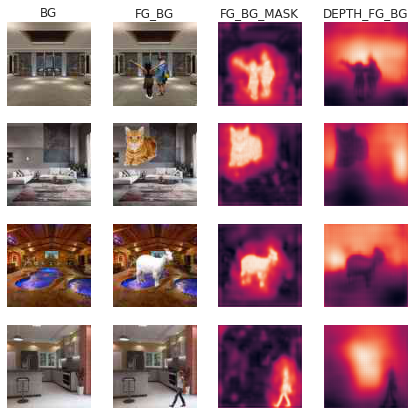

In [0]:
plot4_batch({'fg_bg': data['fg_bg'], 'bg': data['bg'], 'depth_fg_bg': d_out, 'fg_bg_mask': s_out})

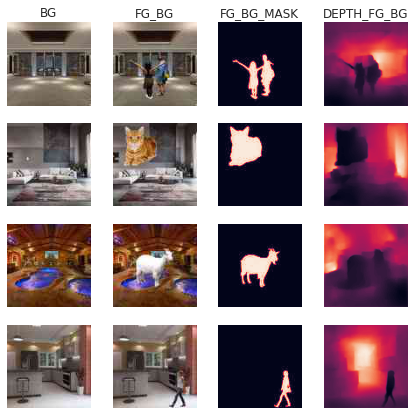

In [0]:
plot4_batch(data)

In [0]:
gc.collect()

206

In [0]:
torch.cuda.empty_cache()

In [0]:
torch.cuda.memory_allocated()

527119872